In [1]:
import torch
import networkx as nx
import torch.optim as optim
import numpy as np
import pickle

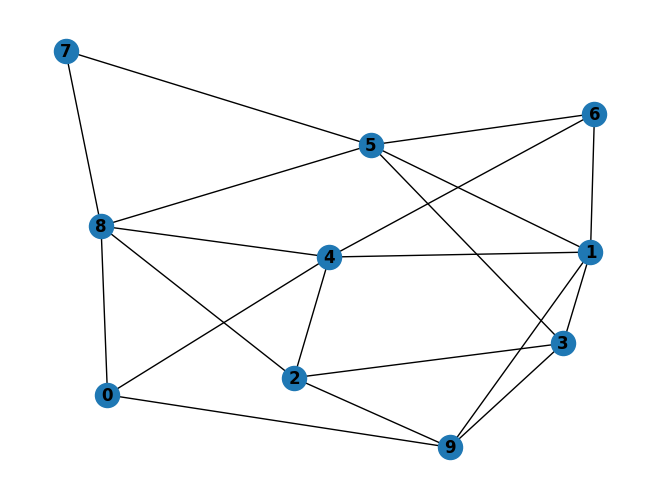

In [2]:
# Define or Load graph:

n = 10  # number of nodes
m = 20  # number of edges
G = nx.gnm_random_graph(n, m, seed = 0)

nx.draw(G, with_labels=True, font_weight='bold')
file_path = "./graphs/er_700-800/ER_700_800_0.15_0.gpickle"

with open(file_path, 'rb') as f:
    G = pickle.load(f)

In [3]:
# Given Matrix_X and A, count the number of edges connecting the two disjoint sets of the max cut problem

def count_cut_edges(X, adjacency_matrix):
    """
    Count the number of edges connecting elements with 1 and 0 values in X.

    Args:
    - X (torch.Tensor): Torch vector with 0 and 1 values.
    - adjacency_matrix (torch.Tensor): Adjacency matrix of the graph.

    Returns:
    - int: Number of edges connecting elements with 1 and 0 values in X.
    """
    # Convert X to a boolean tensor
    X_bool = X.bool()


    # Find indices of elements with value 1 and 0 in X
    indices_1 = torch.nonzero(X_bool).squeeze()
    indices_0 = torch.nonzero(~X_bool).squeeze()


    # Extract submatrix of adjacency_matrix corresponding to connections between 1s and 0s
    adj_submatrix = adjacency_matrix[indices_1][:, indices_0]

    # Count the number of edges between 1s and 0s
    num_cut_edges = torch.sum(adj_submatrix)

    return num_cut_edges.item()


# Example usage:
X = torch.tensor([1, 0, 1, 1, 0])  # Example torch vector with 0 and 1 values
adjacency_matrix = torch.tensor([[0, 1, 0, 1, 0],
                                 [1, 0, 1, 0, 0],
                                 [0, 1, 0, 1, 1],
                                 [1, 0, 1, 0, 0],
                                 [0, 0, 1, 0, 0]])  # Example adjacency matrix

num_edges = count_cut_edges(X, adjacency_matrix)
print("Number of edges connecting elements with 1 and 0 values in X:", num_edges)


Number of edges connecting elements with 1 and 0 values in X: 3


In [4]:
# Mosek MAx CUt SDP

from mosek.fusion import Model, Domain, ObjectiveSense, Matrix, Expr

# Get the adjacency matrix
A = np.array(nx.adjacency_matrix(G).todense())

# Get the number of nodes and edges
n = len(G.nodes)
number_of_edges = len(G.edges)

# Create a MOSEK model
with Model("SDP_init") as m:

    # Create the matrix variable X
    X = m.variable('X', [n, n], Domain.inPSDCone())

    # Compute the trace of AX
    trace_AX = Expr.dot(A, X)

    #trace_AX = Expr.sum(AX.index(i, i) for i in range(n))
    objective_expr = Expr.sub(0.5 * number_of_edges, Expr.mul(0.5, trace_AX ))

    # Set the objective: maximize the trace of X
    m.objective('obj', ObjectiveSense.Maximize, objective_expr)

    # Add constraints: X_{i,i} == 1 for all i in V
    for node in G.nodes:
        i = node
        m.constraint(f'con_{i}_{i}', X.index(i, i), Domain.equalsTo(1.0))


    # Solve the problem
    m.solve()

    # Get the solution
    X_solution = X.level()
    #X_solution = m.getPrimalSolution()

# Display the results
print("Optimal solution (X):")
print(X_solution)
print(X_solution.shape)
X_solution_reshaped = X_solution.reshape(n, n)
for node in G.nodes:
    print(f"Node {node}: {X_solution_reshaped[node,node]}")

# # double checking symmetry:
# for i in range(n):
#     for j in range(n):
#         if i != j:
#             if X_solution_reshaped[i,j] == X_solution_reshaped[j,i]:
#               print("Symmetric")
#             else:
#               print("Not Symmetric")

Optimal solution (X):
[ 1.          0.53965427  0.16506587 ...  0.23300038 -0.35310156
  1.        ]
(592900,)
Node 0: 1.0000000000002447
Node 1: 1.0000000000000164
Node 2: 1.0000000000003377
Node 3: 1.0000000000000848
Node 4: 1.0000000000002789
Node 5: 1.0000000000003844
Node 6: 1.000000000000604
Node 7: 1.0000000000004994
Node 8: 1.0000000000006464
Node 9: 0.9999999999996633
Node 10: 1.000000000000093
Node 11: 0.9999999999990735
Node 12: 1.0000000000005487
Node 13: 1.0000000000005302
Node 14: 0.9999999999998666
Node 15: 1.0000000000003197
Node 16: 1.0000000000005715
Node 17: 1.0000000000013425
Node 18: 1.0000000000002858
Node 19: 1.0000000000002056
Node 20: 1.0000000000003997
Node 21: 1.0000000000007103
Node 22: 0.9999999999994676
Node 23: 1.0000000000004383
Node 24: 1.000000000000442
Node 25: 0.9999999999999617
Node 26: 1.0000000000007199
Node 27: 1.0000000000005815
Node 28: 0.999999999999758
Node 29: 1.0000000000004032
Node 30: 1.0000000000000564
Node 31: 1.0000000000006861
Node 32

In [5]:
# loss function:

adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix_dense = adjacency_matrix.todense()
adjacency_matrix_tensor = torch.tensor(adjacency_matrix_dense, dtype=torch.float32)

# Compute the degree matrix
degree_vector = torch.sum(adjacency_matrix_tensor, dim=1)
degree_matrix = torch.diag(degree_vector)

# Compute the Laplacian matrix
laplacian_matrix = degree_matrix - adjacency_matrix_tensor

def loss_function(laplacian_matrix, Matrix_X):

    ## with edges of the comp graph:
    loss = -(Matrix_X.T @ (laplacian_matrix) @ Matrix_X)
    return loss

[ 8.50865441e-03  9.21528862e-03  5.06071056e-03  4.61507080e-02
 -5.67148718e-02  4.13269853e-02 -5.74598462e-02  5.07107165e-02
 -1.78937518e-02 -2.85023327e-02 -6.31934419e-02  1.32037644e-02
 -6.71059390e-02  7.44895530e-04  2.24161436e-02  1.45591086e-02
 -2.58439471e-03  5.06961194e-02  6.81075800e-04 -1.17503633e-02
 -7.29979048e-02  1.04780861e-02 -1.99502218e-02 -1.24492504e-02
 -1.54729271e-03  3.53750074e-03  3.54518248e-02 -5.11172972e-02
 -2.47031336e-02  2.84377459e-02  6.33269796e-03 -1.21725518e-02
  1.37477231e-02 -8.92380942e-03  2.10859318e-02 -1.95588601e-02
 -4.61702032e-02  2.93687216e-02  3.15854455e-03  1.10652470e-02
  1.98657399e-02  2.15556478e-02 -1.00840725e-02 -1.04655069e-02
  4.51718490e-02  2.06073179e-04 -2.03921773e-02 -3.83935868e-02
  1.13335554e-02 -6.83553991e-03  3.79790437e-02  1.82205205e-03
  1.37723093e-02 -6.13291409e-02 -8.29995528e-02  3.66365118e-02
 -3.95907032e-02 -1.10178767e-02  1.32148881e-02  4.05767746e-03
 -1.66524653e-02 -2.95338

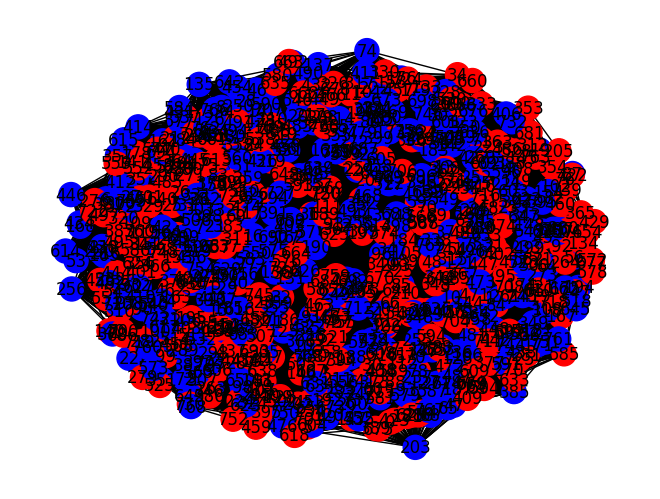

In [6]:
# Spectral Clustering to get the cut from the SDP solution:
#  A commonly used approach is to select the eigenvector corresponding to the second smallest eigenvalue of the matrix obtained from the SDP solution.
# This is often referred to as the Fiedler vector.

# obtaining the eigenvector that correspond to the 2nd smallest eigen value:
def second_smallest_eigenvector(matrix):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)

    # Find the index of the second smallest eigenvalue
    second_smallest_index = np.argsort(eigenvalues)[1]

    # Get the corresponding eigenvector
    second_smallest_eigenvector = eigenvectors[:, second_smallest_index]

    return second_smallest_eigenvector

second_smallest_eigenvector = second_smallest_eigenvector(X_solution_reshaped)

print(second_smallest_eigenvector)

#Use the signs of the entries of the eigenvectors to partition the vertices of the graph into two sets.
# If the entry of an eigenvector corresponding to a vertex is positive, put that vertex in one set; if it's negative, put it in the other set.

# obtain tyhe signs to divide the sets
SDP_cut = np.sign(second_smallest_eigenvector)
SDP_cut = SDP_cut+1
SDP_cut = SDP_cut/2
print(SDP_cut)

SDP_cut_value = count_cut_edges(torch.tensor(SDP_cut), adjacency_matrix_tensor)
print("Number of edges connecting elements with 1 and 0 values from spectral clustering is:", SDP_cut_value)

node_colors = ['blue' if p == 0 else 'red' for p in SDP_cut]
nx.draw(G, with_labels=True, node_color=node_colors)

In [7]:
# Next Steps:
#1 How to encode the SDP solution in the quadratic formulation
#2 The restarting mechanism now is when we get a binary vector. I think it would be best to change it to:
# If the value of the cut does not change for 10 iterations, then restart locally for a few iterations, then restart

In [10]:
# Optimization loop:

# Initialization:
torch.manual_seed(7)
Matrix_X = torch.rand((n), requires_grad=True)

learning_rate_alpha = 0.1
number_of_iterations_T = 100000

optimizer = optim.Adam([Matrix_X], lr=learning_rate_alpha)

best_so_far = 0
for t in range(number_of_iterations_T):

    loss = loss_function(laplacian_matrix, Matrix_X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Box-constraining:
    Matrix_X.data[Matrix_X>=1] =1
    Matrix_X.data[Matrix_X<=0] =0

    thresholded_tensor = (Matrix_X.data > 0).float() # this returns a binary vector to be checked
    #print(thresholded_tensor)
    num_edges = count_cut_edges(thresholded_tensor, adjacency_matrix_tensor)
    if (t + 1) % 1 == 0:
        #print("Iteration:", t, "Loss:", loss.item(), "Number of edges:", num_edges, "Matrix_X:", Matrix_X.data)
        print("Iteration:", t, "Loss:", loss.item(), "Number of edges:", num_edges)

    # Restart when X becomes binary!! This may not be the best way to restart:
    is_binary = ((Matrix_X.data == 0) | (Matrix_X.data == 1)).all()
    if is_binary:
        if num_edges > best_so_far: best_so_far = num_edges
        torch.manual_seed(t)
        Matrix_X = torch.rand((n), requires_grad=True)
        optimizer = optim.Adam([Matrix_X], lr=learning_rate_alpha)
        print("Restarting...", "Iteration:", t, "Loss:", loss.item(), "Number of edges:", num_edges, "current best: ", best_so_far)


Iteration: 0 Loss: -7481.794921875 Number of edges: 8152.0
Iteration: 1 Loss: -11910.2294921875 Number of edges: 14535.0
Iteration: 2 Loss: -15930.375 Number of edges: 19308.0
Iteration: 3 Loss: -19040.646484375 Number of edges: 21468.0
Iteration: 4 Loss: -21144.005859375 Number of edges: 22171.0
Iteration: 5 Loss: -22161.3984375 Number of edges: 22320.0
Iteration: 6 Loss: -22351.322265625 Number of edges: 22356.0
Restarting... Iteration: 6 Loss: -22351.322265625 Number of edges: 22356.0 current best:  22356.0
Iteration: 7 Loss: -7142.10107421875 Number of edges: 6698.0
Iteration: 8 Loss: -11567.005859375 Number of edges: 13368.0
Iteration: 9 Loss: -15653.62109375 Number of edges: 18593.0
Iteration: 10 Loss: -18985.212890625 Number of edges: 21264.0
Iteration: 11 Loss: -21180.15625 Number of edges: 22241.0
Iteration: 12 Loss: -22211.26171875 Number of edges: 22357.0
Iteration: 13 Loss: -22404.255859375 Number of edges: 22408.0
Restarting... Iteration: 13 Loss: -22404.255859375 Number o

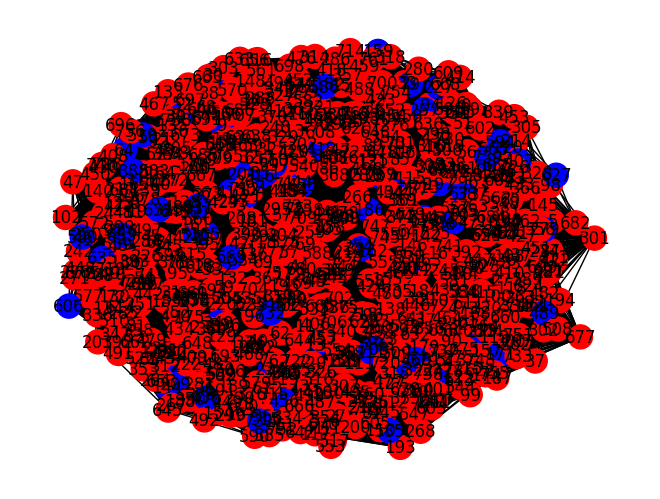

In [9]:
# testing the validity for n = 10 and m = 20
cut = Matrix_X.data
node_colors = ['blue' if p == 0 else 'red' for p in cut]
nx.draw(G, with_labels=True, node_color=node_colors)